We import needed libraries and methods.

In [10]:
import os

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import numpy as np
from matplotlib.scale import ScaleBase, register_scale
from matplotlib.ticker import FuncFormatter
from scipy.interpolate import interp1d
from scipy.stats import binom

We load the files with p values calculated for shuffled real world data with no differences between the groups.

In [11]:
p_values_pool_list = []

for file in os.listdir('data/p_values/'):
    p_values_from_file = np.loadtxt(f'data/p_values/{file}', delimiter='\t')
    p_values_pool_list.append(p_values_from_file)

p_values_pool = np.column_stack(p_values_pool_list) 

In [12]:
adjusted_p_values_pool_list = []

for file in os.listdir('data/adjusted_p_values/'):
    adjusted_p_values_from_file = np.loadtxt(f'data/adjusted_p_values/{file}', delimiter='\t')
    adjusted_p_values_pool_list.append(adjusted_p_values_from_file)

adjusted_p_values_pool = np.column_stack(adjusted_p_values_pool_list) 

In [13]:
adjusted_bonferroni_p_values_pool_list = []

for file in os.listdir('data/adjusted_p_values_bonferroni/'):
    adjusted_bonferroni_p_values_from_file = np.loadtxt(f'data/adjusted_p_values_bonferroni/{file}', delimiter='\t')
    adjusted_bonferroni_p_values_pool_list.append(adjusted_bonferroni_p_values_from_file)

adjusted_bonferroni_p_values_pool = np.column_stack(adjusted_bonferroni_p_values_pool_list) 

We plot the histogram of number of significant findings in p values pools.

In [14]:
# Define the Pseudolog Transform class
class PseudoLogTransform(mtransforms.Transform):
    input_dims = 1
    output_dims = 1
    is_separable = True

    def transform_non_affine(self, a):
        return np.sign(a) * np.log1p(np.abs(a))

    def inverted(self):
        return InversePseudoLogTransform()

class InversePseudoLogTransform(mtransforms.Transform):
    input_dims = 1
    output_dims = 1
    is_separable = True

    def transform_non_affine(self, a):
        return np.sign(a) * (np.expm1(np.abs(a)))

    def inverted(self):
        return PseudoLogTransform()

# Register the custom transform
class PseudoLogScale(ScaleBase):
    name = 'pseudolog'

    def __init__(self, axis, **kwargs):
        pass

    def get_transform(self):
        return PseudoLogTransform()

    def set_default_locators_and_formatters(self, axis, **kwargs):
        axis.set_major_formatter(FuncFormatter(self.format_func))

    def format_func(self, val, pos):
        if val == 0:
            return '0'
        else:
            exponent = int(np.log10(np.abs(val)))
            return f'$10^{{{exponent}}}$'

    def limit_range_for_scale(self, vmin, vmax, minpos):
        return vmin, vmax

register_scale(PseudoLogScale)

In [15]:
def pseudolog_transform(x):
    return np.sign(x) * np.log1p(np.abs(x))

# Inverse pseudolog transformation function
def inverse_pseudolog_transform(y):
    return np.sign(y) * (np.expm1(np.abs(y)))

def plot_histogram_and_binomial_with_log_bars(alpha, p_values_pool, bins_number, color, is_adjusted=False, adjustment='none', offset=0):
    p_values_pool_binary = p_values_pool < alpha
    number_of_trues_p_values_pool_binary = np.sum(p_values_pool_binary, axis=0)
    n = p_values_pool_binary.shape[0]
    p = np.mean(number_of_trues_p_values_pool_binary) / n
    mean_value = np.mean(number_of_trues_p_values_pool_binary)    
    
    if(is_adjusted):
        min_value = 0
        max_value = 10000
    else:
        min_value = number_of_trues_p_values_pool_binary.min()
        max_value = number_of_trues_p_values_pool_binary.max()

    pseudolog_min = pseudolog_transform(min_value)
    pseudolog_max = pseudolog_transform(max_value)
    pseudolog_bins = np.linspace(pseudolog_min, pseudolog_max, bins_number)
    bin_edges = inverse_pseudolog_transform(pseudolog_bins)
    
    #hist_values, bin_edges, patches = plt.hist(number_of_trues_p_values_pool_binary, bins=bin_edges, alpha=0.8, color=color, label=f'Empirical histogram for alpha={alpha}')
    hist_values, bin_edges = np.histogram(number_of_trues_p_values_pool_binary, bins=bin_edges)
    if offset > 0:
        hist_values = np.concatenate([np.zeros(offset), hist_values[:-offset]])
    
    # Now you can plot the histogram manually if needed
    if(is_adjusted):
        plt.stairs(hist_values, bin_edges, fill=True, color=color, alpha=0.8, label=f'Empirical histogram for alpha={alpha} \n ({adjustment} adjustment)')
    else:
        plt.stairs(hist_values, bin_edges, fill=True, color=color, alpha=0.8, label=f'Empirical histogram for alpha={alpha}')
    
    # Create the range of values between 1 and n+1
    x = np.arange(0, n+1)
    pmf = binom.pmf(x, n, p)
    scaled_pmf = pmf * n
    
    x_interp = np.linspace(0, 1, 1000)
    interp_func = interp1d(x, scaled_pmf, kind='cubic')
    smoothed_pmf = interp_func(x_interp)
    
    plt.axvline(mean_value, color=color, linestyle='--', label=f'Mean number of significant p-values ({mean_value:.2f})')
    
    # Uncomment if you want to plot binomials as well
    # Combine the interpolated part with the original data
    x_combined = np.concatenate([x_interp, x[1:]])
    pmf_combined = np.concatenate([smoothed_pmf, scaled_pmf[1:]])
    
    # p_str = f"{p:.2e}"
    # if(is_adjusted):
    #     plt.plot(x_combined, pmf_combined, color=color, label=f'Binomial distribution for n={n}, p={p_str} \n ({adjustment} adjustment)')
    # else:
    #     plt.plot(x, scaled_pmf, color=color, label=f'Binomial distribution for n={n}, p={p_str}')
    
    ticks = [0] + [10**i for i in range(int(np.log10(x.max())) + 1)]
    plt.gca().set_xticks(ticks)
    plt.gca().set_yticks(ticks)
    plt.gca().get_xaxis().set_major_formatter(FuncFormatter(lambda x, _: f'$10^{{{int(np.log10(x))}}}$' if x != 0 else '0'))
    plt.gca().get_yaxis().set_major_formatter(FuncFormatter(lambda y, _: f'$10^{{{int(np.log10(y))}}}$' if y != 0 else '0'))

    return p_values_pool_binary, number_of_trues_p_values_pool_binary

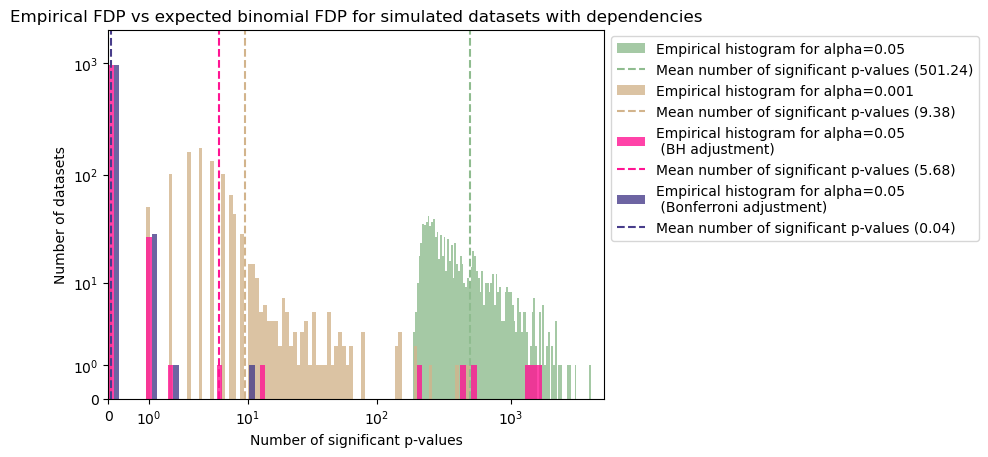

In [16]:
p_values_pool_binary_log_bars_0_05, number_of_trues_p_values_pool_binary_log_bars_0_05 = plot_histogram_and_binomial_with_log_bars(0.05, p_values_pool, 100, color='darkseagreen')
p_values_pool_binary_log_bars_0_001, number_of_trues_p_values_pool_binary_log_bars_0_001 = plot_histogram_and_binomial_with_log_bars(0.001, p_values_pool, 100, color='tan')
p_values_pool_binary_log_bars_adjusted_0_05, number_of_trues_p_values_pool_binary_log_bars_adjusted_0_05 = plot_histogram_and_binomial_with_log_bars(0.05, adjusted_p_values_pool, 100, color='deeppink', is_adjusted=True, adjustment="BH")
p_values_pool_binary_log_bars_adjusted_bonferroni_0_05, number_of_trues_p_values_pool_binary_log_bars_adjusted_bonferroni_0_05 = plot_histogram_and_binomial_with_log_bars(0.05, adjusted_bonferroni_p_values_pool, 100, color='darkslateblue', is_adjusted=True, adjustment="Bonferroni", offset=1)

plt.xlabel('Number of significant p-values')
plt.ylabel('Number of datasets')
plt.title('Empirical FDP vs expected binomial FDP for simulated datasets with dependencies')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.xscale('pseudolog')
plt.yscale('pseudolog')

plt.xlim(0, 5000)
plt.ylim(0, 2000)
plt.show()

We repeat similar analysis for real-world data.

In [17]:
p_values_pool_list_real_world = []

for file in os.listdir('data/p_values_real_world/'):
    p_values_from_file_real_world = np.loadtxt(f'data/p_values_real_world/{file}', delimiter='\t')
    p_values_pool_list_real_world.append(p_values_from_file_real_world)

p_values_pool_real_world = np.column_stack(p_values_pool_list_real_world) 

In [18]:
adjusted_p_values_pool_list_real_world = []

for file in os.listdir('data/adjusted_p_values_real_world/'):
    adjusted_p_values_from_file_real_world = np.loadtxt(f'data/adjusted_p_values_real_world/{file}', delimiter='\t')
    adjusted_p_values_pool_list_real_world.append(adjusted_p_values_from_file_real_world)

adjusted_p_values_pool_real_world = np.column_stack(adjusted_p_values_pool_list_real_world) 

In [19]:
adjusted_bonferroni_p_values_pool_list_real_world = []

for file in os.listdir('data/adjusted_p_values_real_world_bonferroni/'):
    adjusted_bonferroni_p_values_from_file_real_world = np.loadtxt(f'data/adjusted_p_values_real_world_bonferroni/{file}', delimiter='\t')
    adjusted_bonferroni_p_values_pool_list_real_world.append(adjusted_bonferroni_p_values_from_file_real_world)

adjusted_bonferroni_p_values_pool_real_world = np.column_stack(adjusted_bonferroni_p_values_pool_list_real_world) 

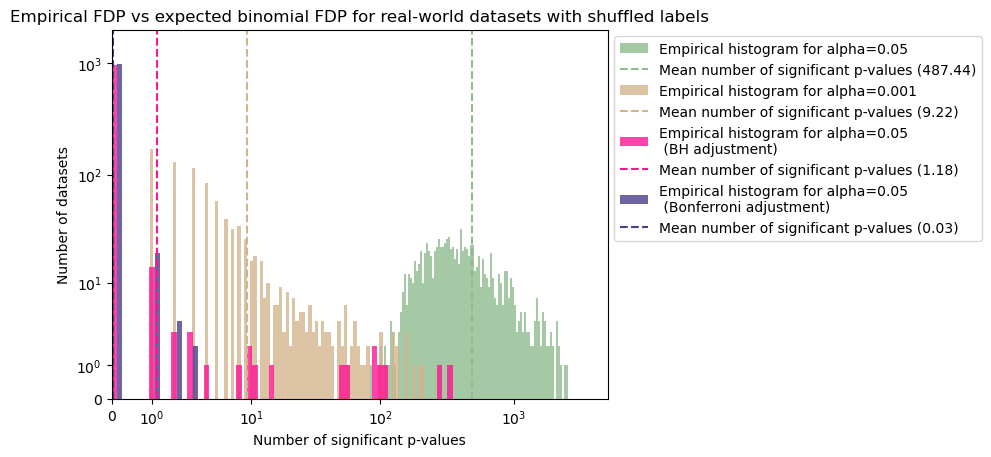

In [20]:
p_values_pool_binary_log_bars_0_05_real_world, number_of_trues_p_values_pool_binary_log_bars_0_05_real_world = plot_histogram_and_binomial_with_log_bars(0.05, p_values_pool_real_world, 100, color='darkseagreen')
p_values_pool_binary_log_bars_0_001_real_world, number_of_trues_p_values_pool_binary_log_bars_0_001_real_world = plot_histogram_and_binomial_with_log_bars(0.001, p_values_pool_real_world, 100, color='tan')
p_values_pool_binary_log_bars_adjusted_0_05_real_world, number_of_trues_p_values_pool_binary_log_bars_adjusted_0_05_real_world = plot_histogram_and_binomial_with_log_bars(0.05, adjusted_p_values_pool_real_world, 100, color='deeppink', is_adjusted=True, adjustment="BH")
p_values_pool_binary_log_bars_adjusted_bonferroni_0_05_real_world, number_of_trues_p_values_pool_binary_log_bars_adjusted_bonferroni_0_05_real_world = plot_histogram_and_binomial_with_log_bars(0.05, adjusted_bonferroni_p_values_pool_real_world, 100, color='darkslateblue', is_adjusted=True, adjustment="Bonferroni", offset=1)

plt.xlabel('Number of significant p-values')
plt.ylabel('Number of datasets')
plt.title('Empirical FDP vs expected binomial FDP for real-world datasets with shuffled labels')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.xscale('pseudolog')
plt.yscale('pseudolog')

plt.xlim(0, 5000)
plt.ylim(0, 2000)
plt.show()